THIS FILE IS TO EXECUTE 2D CNN WITH THE DATASET TO CHECK ITS PERFORMANCE

In [ ]:
# req libraries
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

# tensorFlow and keras lib
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

%matplotlib inline


In [ ]:
# resizing , setting batch size for training

IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32

#  dataset directory
dataset_directory = 'CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone'  

#no of class for classification
classes = ['Cyst', 'Normal', 'Stone', 'Tumor']


In [ ]:
import shutil
from sklearn.model_selection import train_test_split

# Create directories for train, validation, and test sets
base_dir = 'kidney_split_dataset' 

if not os.path.exists(base_dir):
    os.makedirs(base_dir)
    os.makedirs(os.path.join(base_dir, 'train'))
    os.makedirs(os.path.join(base_dir, 'validation'))
    os.makedirs(os.path.join(base_dir, 'test'))

    for subset in ['train', 'validation', 'test']:
        for class_name in classes:
            os.makedirs(os.path.join(base_dir, subset, class_name))

    # data split into train val , test
    for class_name in classes:
        class_dir = os.path.join(dataset_directory, class_name)
        images = os.listdir(class_dir)
        train_val_images, test_images = train_test_split(images, test_size=0.1, random_state=42)
        train_images, val_images = train_test_split(train_val_images, test_size=0.1111, random_state=42)  # Approx. 10% for validation

       
        # training imgs
        for img in train_images:
            src = os.path.join(class_dir, img)
            dst = os.path.join(base_dir, 'train', class_name, img)
            shutil.copyfile(src, dst)

       
        # validation imgs
        for img in val_images:
            src = os.path.join(class_dir, img)
            dst = os.path.join(base_dir, 'validation', class_name, img)
            shutil.copyfile(src, dst)

       
        # test imgs
        for img in test_images:
            src = os.path.join(class_dir, img)
            dst = os.path.join(base_dir, 'test', class_name, img)
            shutil.copyfile(src, dst)


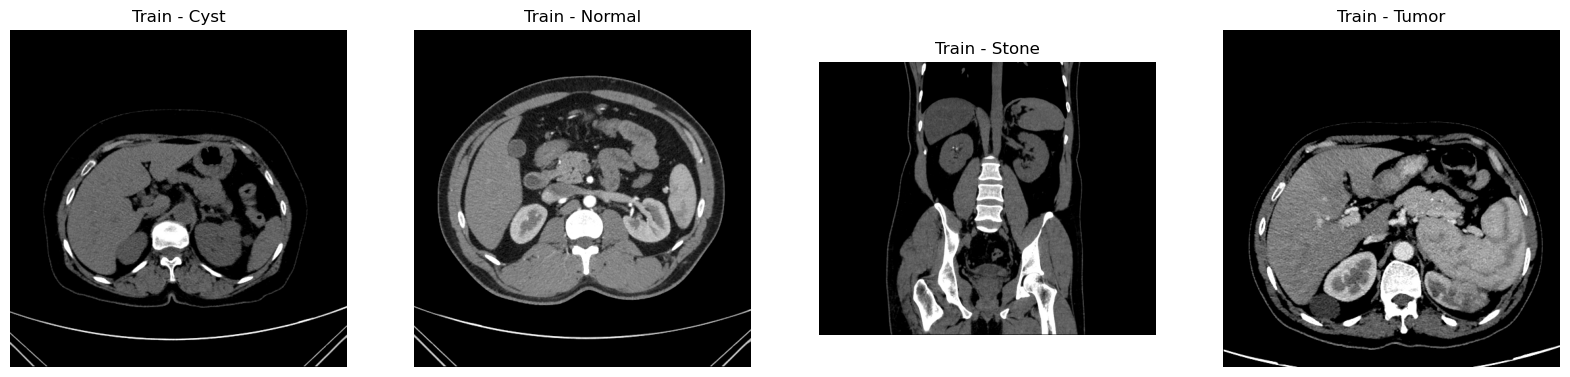

In [6]:
# visualize samples imgs of training set 

import os
import random  
from PIL import Image
import matplotlib.pyplot as plt

classes = ['Cyst', 'Normal', 'Stone', 'Tumor']
base_dir = 'kidney_split_dataset'  

def visualize_samples(directory, subset='train'):

    fig, axes = plt.subplots(nrows=1, ncols=len(classes), figsize=(20, 5))

    for i, class_name in enumerate(classes):
        class_dir = os.path.join(directory, subset, class_name)
        img_list = os.listdir(class_dir)
        if not img_list:
            print(f"No images found in {class_dir}")
            axes[i].axis('off')
            axes[i].set_title(f'{subset.capitalize()} - {class_name} (No images)')
            continue
        img_name = random.choice(img_list)
        img_path = os.path.join(class_dir, img_name)
        try:
            img = Image.open(img_path)
            axes[i].imshow(img, cmap='gray')
            axes[i].set_title(f'{subset.capitalize()} - {class_name}')
            axes[i].axis('off')
        except Exception as e:
            print(f"Error opening image {img_path}: {e}")
            axes[i].axis('off')
            axes[i].set_title(f'{subset.capitalize()} - {class_name} (Error)')

    plt.show()


visualize_samples(base_dir, 'train')


In [ ]:
# pre processing imgs and normalizing
def preprocess_image(image):
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
  
    if image.shape[-1] == 3:
        image = tf.image.rgb_to_grayscale(image)
   
    image = image / 255.0
    return image


In [ ]:
# data sugmented for better generalization
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal_and_vertical'),
    layers.RandomRotation(0.2),
])


In [9]:
# data generators for train , validation and test

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_image
)

validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_image
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_image
)

# for train
train_generator = train_datagen.flow_from_directory(
    directory=os.path.join(base_dir, 'train'),
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    color_mode='grayscale',
    class_mode='categorical',
    shuffle=True
)

# for validation
validation_generator = validation_datagen.flow_from_directory(
    directory=os.path.join(base_dir, 'validation'),
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    color_mode='grayscale',
    class_mode='categorical',
    shuffle=False
)

# test
test_generator = test_datagen.flow_from_directory(
    directory=os.path.join(base_dir, 'test'),
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    color_mode='grayscale',
    class_mode='categorical',
    shuffle=False
)


Found 9954 images belonging to 4 classes.
Found 1246 images belonging to 4 classes.
Found 1246 images belonging to 4 classes.


In [ ]:
# using resnet-50 

base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
)


In [ ]:
# Freeze the base model
base_model.trainable = False


# custom model
model = models.Sequential([

    layers.InputLayer(input_shape=(IMG_HEIGHT, IMG_WIDTH, 1)),  
    layers.Lambda(lambda x: tf.image.grayscale_to_rgb(x)),   

    data_augmentation,                                         
    base_model,            

    layers.GlobalAveragePooling2D(), 

    layers.Dense(1024, activation='relu'),                    
    layers.Dropout(0.5),   
                                        
    layers.Dense(len(classes), activation='softmax')           
])


In [12]:
# complie model and show info about layers with respective parameter\

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 224, 224, 3)       0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                      

In [13]:
# no of epochs set to train the model

EPOCHS = 20


history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS
)


Epoch 1/20
312/312 [==============================] - 152s 459ms/step - loss: 1.2936 - accuracy: 0.4458 - val_loss: 1.1159 - val_accuracy: 0.5770
Epoch 2/20
312/312 [==============================] - 87s 280ms/step - loss: 1.1168 - accuracy: 0.5553 - val_loss: 1.0600 - val_accuracy: 0.5787
Epoch 3/20
312/312 [==============================] - 82s 262ms/step - loss: 1.0556 - accuracy: 0.5824 - val_loss: 1.0531 - val_accuracy: 0.5827
Epoch 4/20
312/312 [==============================] - 90s 289ms/step - loss: 1.0132 - accuracy: 0.5944 - val_loss: 0.9849 - val_accuracy: 0.6059
Epoch 5/20
312/312 [==============================] - 80s 257ms/step - loss: 0.9846 - accuracy: 0.6037 - val_loss: 1.0090 - val_accuracy: 0.5835
Epoch 6/20
312/312 [==============================] - 90s 287ms/step - loss: 0.9528 - accuracy: 0.6167 - val_loss: 0.9711 - val_accuracy: 0.6091
Epoch 7/20
312/312 [==============================] - 95s 303ms/step - loss: 0.9260 - accuracy: 0.6285 - val_loss: 0.9158 - val_a

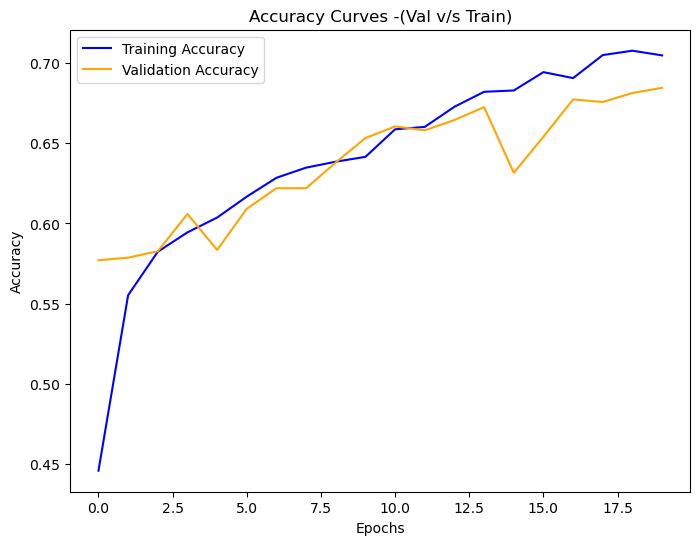

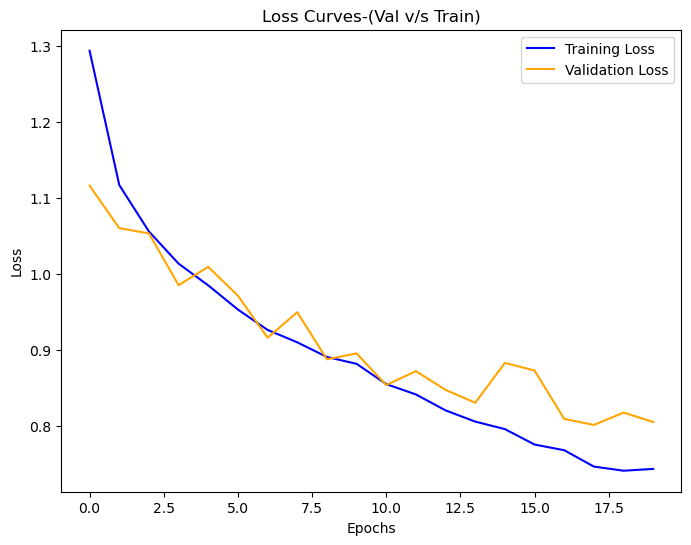

In [14]:
# Function to plot training history
def plot_training_history(history):

    # plots accuracy wrto epochs
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
    plt.title('Accuracy Curves -(Val v/s Train)')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # plots loss wrto epochs
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.title('Loss Curves-(Val v/s Train)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_training_history(history)


39/39 [==============================] - 20s 486ms/step


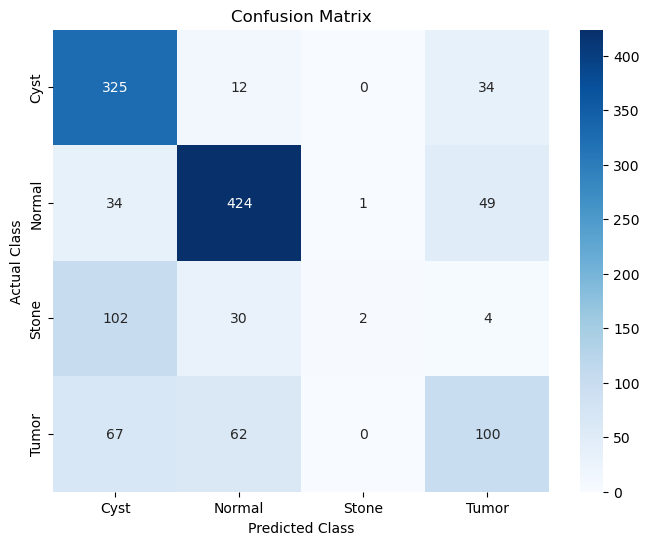

Classification Report:
              precision    recall  f1-score   support

        Cyst       0.62      0.88      0.72       371
      Normal       0.80      0.83      0.82       508
       Stone       0.67      0.01      0.03       138
       Tumor       0.53      0.44      0.48       229

    accuracy                           0.68      1246
   macro avg       0.65      0.54      0.51      1246
weighted avg       0.68      0.68      0.64      1246



In [15]:
# performance evaluation of test data

def evaluate_model(model, test_generator):

    test_steps = test_generator.samples // test_generator.batch_size + 1
    predictions = model.predict(test_generator, steps=test_steps)
    y_pred = np.argmax(predictions, axis=1)
    y_true = test_generator.classes

    # confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_df = pd.DataFrame(cm, index=classes, columns=classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Class')
    plt.xlabel('Predicted Class')
    plt.show()

    # classification report
    report = classification_report(y_true, y_pred, target_names=classes)
    print('Classification Report:')
    print(report)



evaluate_model(model, test_generator)


Conclusion of using resnet-50 for feature extraction and predicted with custom model:
(2D CNN structure)

1.Overall performance very mediocre
2.Poor perfomance of validation as compared to train suggesting overfitting of training data
3.Poor recall scores for stone and tumor classes
4.Trainable parameters out of total parameters is only 12.22%